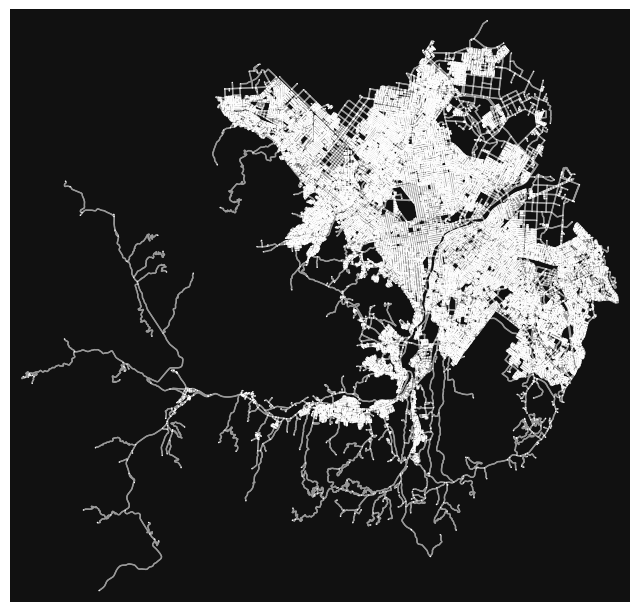

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [1]:
# 札幌市の道路ネットワークを取得し、ポート情報を追加するスクリプト。概観。
import networkx as nx; import osmnx as ox 
g = ox.graph_from_place("Sapporo, Hokkaido, Japan", network_type="drive")
ox.plot_graph(g, node_size=1)

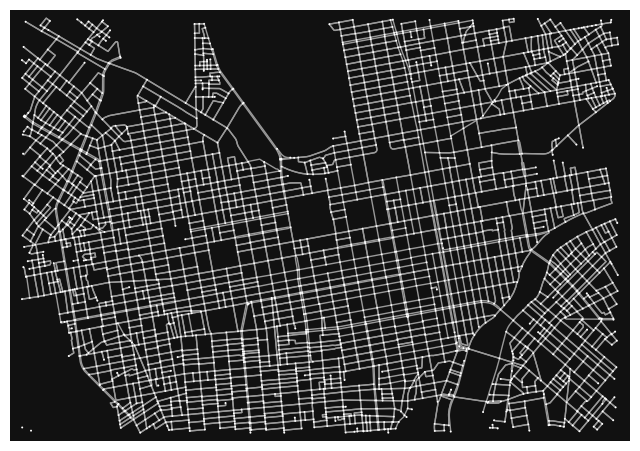

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [2]:
# クリッピング
import networkx as nx; import osmnx as ox 
from shapely.geometry import Polygon
# g = ox.graph_from_place("Chuo-ku, Sapporo, Hokkaido, Japan", network_type="drive")
south = 43.046
north = 43.08
west = 141.31
east = 141.377
polygon = Polygon([
    (west, south),
    (west, north),
    (east, north),
    (east, south),
    ])
g_poro = ox.truncate.truncate_graph_polygon(g, polygon)
ox.plot_graph(g_poro, node_size = 2)

In [3]:
# ノード情報を見てみる
list(g.nodes(data=True))[:3]    

[(262766642,
  {'y': 43.0904303,
   'x': 141.2695566,
   'highway': 'traffic_signals',
   'street_count': 4}),
 (262766666, {'y': 43.1215719, 'x': 141.2320627, 'street_count': 3}),
 (262766817,
  {'y': 43.0932374,
   'x': 141.2841259,
   'highway': 'traffic_signals',
   'street_count': 5})]

In [4]:
# エッジ情報を見てみる
list(g.edges(data=True))[:3]

[(262766642,
  1801506931,
  {'osmid': 24268925,
   'highway': 'trunk',
   'lanes': '2',
   'name': '札幌新道',
   'oneway': True,
   'ref': '5',
   'reversed': False,
   'length': np.float64(48.62276758744423)}),
 (262766642,
  368222931,
  {'osmid': 153308535,
   'highway': 'trunk_link',
   'lanes': '2',
   'name': '北5条手稲通',
   'oneway': True,
   'ref': '5',
   'reversed': False,
   'length': np.float64(35.72965962458901)}),
 (262766666,
  8823685886,
  {'osmid': 1095767622,
   'highway': 'trunk',
   'lanes': '2',
   'name': '北5条手稲通',
   'oneway': True,
   'ref': '5',
   'reversed': False,
   'length': np.float64(66.6403785985187)})]

In [5]:
from geopy.geocoders import Nominatim

geolocator = Nominatim(user_agent="sapporo-path")

# 店舗A・Bの住所を指定
address_A = "札幌市中央区南4条西21丁目"
address_B = "札幌市中央区北5条西1丁目"

# 緯度経度取得
location_A = geolocator.geocode(address_A)
location_B = geolocator.geocode(address_B)

point_A = (location_A.latitude, location_A.longitude)
point_B = (location_B.latitude, location_B.longitude)


In [6]:
node_A = ox.distance.nearest_nodes(g, X=point_A[1], Y=point_A[0])
node_B = ox.distance.nearest_nodes(g, X=point_B[1], Y=point_B[0])


In [7]:
# JSONを読み込んで変換
# 変換後はポートごとに一つの辞書を割り当て、リスト形式で読み込める。
import json

with open('porocle_port.json', encoding='utf-8') as f:
    data = json.load(f)

fields = [f['id'] for f in data['fields']]
records = data['records']

# 1レコード＝1辞書のリストに変換
ports = [dict(zip(fields, rec)) for rec in records]

# 必要なカラムだけ抽出してもOK
# ports = [
#     {
#         "id": rec["ポート番号"],
#         "name": rec["ポート名称"],
#         "address": rec["住所"],
#         "latitude": rec["緯度経度 (緯度)"],
#         "longitude": rec["緯度経度 (経度)"]
#     }
#     for rec in ports
# ]

with open('porocle_portinfo.json', 'w', encoding='utf-8') as f:
    json.dump(ports, f, ensure_ascii=False, indent=2)

In [24]:
import numpy as np

# 1. 各ポートをネットワークノードにマッピング
for port in ports:
    port['node'] = ox.distance.nearest_nodes(g_poro, X=port["緯度経度 (経度)"], Y=port["緯度経度 (緯度)"])

# 2. 距離行列を作成
n_ports = len(ports)
distance_matrix = np.zeros((n_ports, n_ports))

for i, port_i in enumerate(ports):
    for j, port_j in enumerate(ports):
        if i == j:
            distance_matrix[i, j] = 0
        else:
            try:
                length = nx.shortest_path_length(g_poro, port_i['node'], port_j['node'], weight='length')
                distance_matrix[i, j] = length
            except nx.NetworkXNoPath:
                distance_matrix[i, j] = np.nan  # 経路がなければNaN

# 3. 距離行列をpandas DataFrameに（オプション）
import pandas as pd
port_names = list(p["ポート名称"] for p in ports)
df_dist = pd.DataFrame(distance_matrix, index=port_names, columns=port_names)
df_dist.to_csv("porocle_interport_distance_matrix.csv")

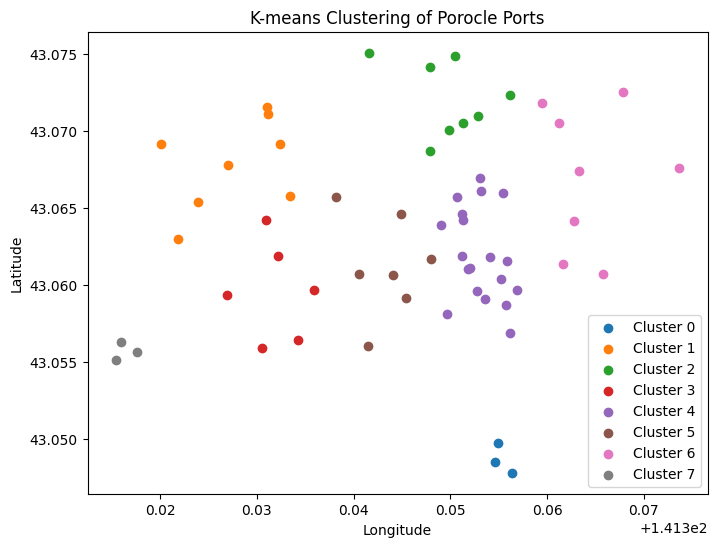

In [9]:
from sklearn.cluster import KMeans
import numpy as np

# 緯度・経度の配列を作成
coords = np.array([[p["緯度経度 (緯度)"], p["緯度経度 (経度)"]] for p in ports])

# クラスタ数を指定（例: 5）
n_clusters = 8
kmeans = KMeans(n_clusters=n_clusters, random_state=0, n_init='auto')
labels = kmeans.fit_predict(coords)

# 各ポートにクラスタ番号を付与
for port, label in zip(ports, labels):
    port["cluster"] = int(label)

# クラスタごとに色分けして地図に可視化も可能
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
for i in range(n_clusters):
    cluster_points = coords[labels == i]
    plt.scatter(cluster_points[:,1], cluster_points[:,0], label=f"Cluster {i}")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend()
plt.title("K-means Clustering of Porocle Ports")
plt.show()

/tmp/ipykernel_1299/488498658.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', n_clusters)


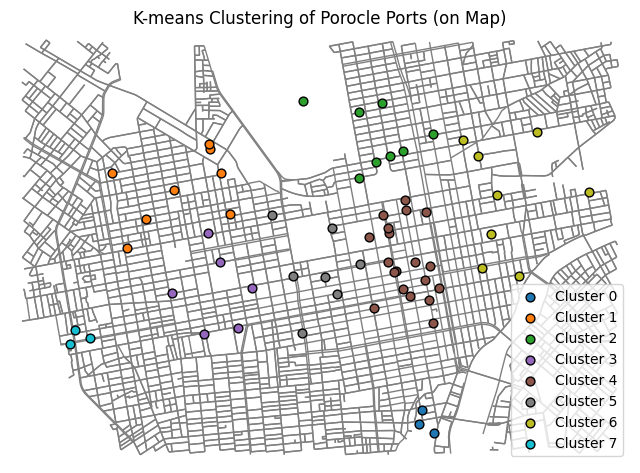

In [10]:
import matplotlib.pyplot as plt
import osmnx as ox

fig, ax = ox.plot_graph(g_poro, show=False, close=False, node_size=0, edge_color='gray', bgcolor='white')

# クラスタごとに色分けしてポートを重ねる
colors = plt.cm.get_cmap('tab10', n_clusters)
for i in range(n_clusters):
    cluster_points = coords[labels == i]
    ax.scatter(cluster_points[:,1], cluster_points[:,0], 
               color=colors(i), label=f"Cluster {i}", s=40, edgecolor='k')

plt.legend()
plt.title("K-means Clustering of Porocle Ports (on Map)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

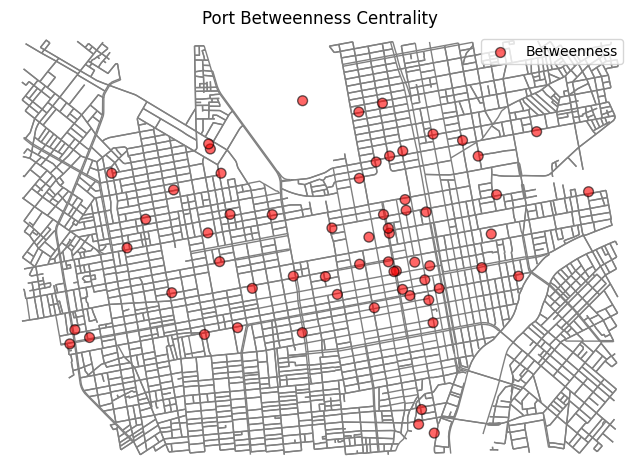

In [11]:
import networkx as nx

# ポートが存在するノードのみで中心性を計算
port_nodes = [p['node'] for p in ports]
subgraph = g_poro.subgraph(port_nodes)
betweenness = nx.betweenness_centrality(subgraph, weight='length')

# ポート情報に中心性スコアを付与
for port in ports:
    port['betweenness'] = betweenness.get(port['node'], 0)

# 中心性の高いポートを地図上で大きく表示
import matplotlib.pyplot as plt
fig, ax = ox.plot_graph(g_poro, show=False, close=False, node_size=0, edge_color='gray', bgcolor='white')
sizes = [50 + 900*port['betweenness'] for port in ports]
ax.scatter([p["緯度経度 (経度)"] for p in ports], [p["緯度経度 (緯度)"] for p in ports],
           s=sizes, c='red', alpha=0.6, edgecolor='k', label='Betweenness')
plt.legend()
plt.title("Port Betweenness Centrality")
plt.show()

Text(0.5, 1.0, 'DBSCAN Clustering (200m radius)')

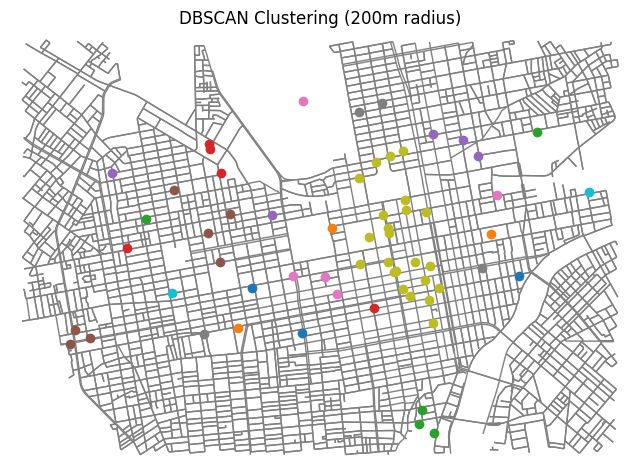

In [12]:
from sklearn.cluster import DBSCAN
import numpy as np

# 緯度・経度をラジアンに変換（球面距離計算のため）
coords = np.array([[p["緯度経度 (緯度)"], p["緯度経度 (経度)"]] for p in ports])
coords_rad = np.radians(coords)

# DBSCANで200m以内をクラスタ化（haversine距離、eps=200m/地球半径）
kms_per_radian = 6371.0088
epsilon = 0.3 / kms_per_radian  # 0.2km = 200m

db = DBSCAN(eps=epsilon, min_samples=1, algorithm='ball_tree', metric='haversine')
labels = db.fit_predict(coords_rad)

# クラスタ番号を付与
for port, label in zip(ports, labels):
    port["cluster_200m"] = int(label)

# 可視化
import matplotlib.pyplot as plt
fig, ax = ox.plot_graph(g_poro, show=False, close=False, node_size=0, edge_color='gray', bgcolor='white')

for i in np.unique(labels):
    cluster_points = coords[labels == i]
    ax.scatter(cluster_points[:,1], cluster_points[:,0], label=f"Cluster {i}")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
# fig.legend()
ax.set_title("DBSCAN Clustering (200m radius)")

/tmp/ipykernel_1299/2678001504.py:32: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color_list = plt.cm.get_cmap('tab10', len(set(clusters.values())))
/tmp/ipykernel_1299/2678001504.py:35: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', len(set(clusters.values())))


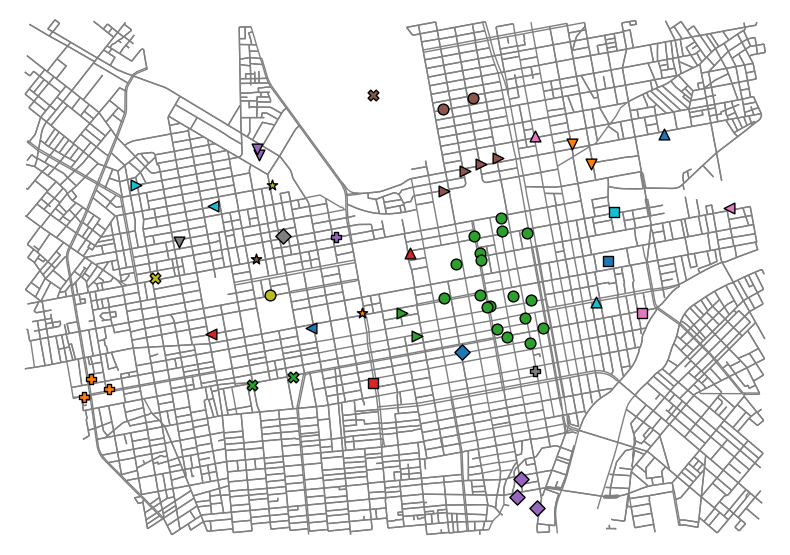

In [32]:
import networkx as nx
import numpy as np
import random 
# 距離行列: distance_matrix（n_ports x n_ports, メートル単位）
# ポート名リスト: port_names

# 1. 200m以下のペアにエッジを張るグラフを作成
radius = 300
G = nx.Graph()
random.shuffle(port_names)
port_names = random.sample(port_names, len(port_names))
for i, name_i in enumerate(port_names):
    G.add_node(i)
    for j, name_j in enumerate(port_names):
        if i < j and distance_matrix[i, j] < radius:
            G.add_edge(i, j)

# 2. 連結成分ごとにクラスタIDを付与
clusters = {}
for cluster_id, component in enumerate(nx.connected_components(G)):
    for idx in component:
        clusters[idx] = cluster_id

# 3. ポート情報にクラスタIDを付与
for i, port in enumerate(ports):
    port["diameter200m_cluster"] = clusters.get(i, -1)

# 4. 可視化例
import matplotlib.pyplot as plt

# 色とマーカーのリスト（必要に応じて増やす）
color_list = plt.cm.get_cmap('tab10', len(set(clusters.values())))
marker_list = ['<', 's', '^', 'D', 'v', 'P', '*', 'X', 'o', '>']

colors = plt.cm.get_cmap('tab10', len(set(clusters.values())))
coords = np.array([[p["緯度経度 (緯度)"], p["緯度経度 (経度)"]] for p in ports])
fig, ax = ox.plot_graph(g_poro, show=False, close=False, node_size=0, edge_color='gray', bgcolor='white')

for idx, cid in enumerate(sorted(set(clusters.values()))):
    cluster_points = coords[[i for i, c in clusters.items() if c == cid]]
    color = color_list(idx % color_list.N)
    marker = marker_list[idx % len(marker_list)]
    ax.scatter(cluster_points[:,1], cluster_points[:,0], 
               color=color, marker=marker, label=f"Cluster {cid}", s=60, edgecolor='k')

# for cid in set(clusters.values()):
#     cluster_points = coords[[i for i, c in clusters.items() if c == cid]]
#     ax.scatter(cluster_points[:,1], cluster_points[:,0], label=f"Cluster {cid}")
# ax.set_title(f"Clusters with Diameter ≤ {radii}m (network distance)")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
# fig.legend(ncol = 3)
fig.tight_layout()